## Frequency estimation from a seismic image

In [1]:
from numpy.fft import rfft, irfft
from numpy import argmax, mean, diff, log
from matplotlib.mlab import find
from scipy.signal import blackmanharris, fftconvolve
import scipy.stats
 
from parabolic import parabolic

A test image [from Berkeley](https://math.berkeley.edu/~sethian/2006/Applications/Seismic/elf-fmg2.jpg)... The image is 2000 ms tall and 12 km across.

<img src="https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_2000ms_12000m.png" width="240px" />

Here is [another](https://math.berkeley.edu/~sethian/2006/Applications/Seismic/smooth_elf_post_img.jpg) and [another](https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg).

### Read an image

In [2]:
from scipy import misc, ndimage

In [3]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_2000ms_12000m.png"
url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_3000ms_8000m.png"
r = requests.get(url)
im = Image.open(BytesIO(r.content))

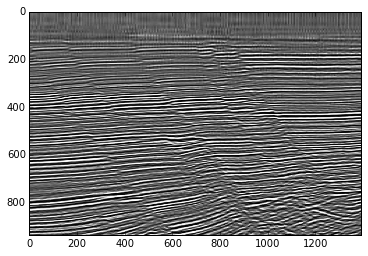

In [61]:
plt.imshow(im)
plt.show()

In [62]:
i = np.asarray(im, dtype=int)
np.mean(i)

138.70377834420131

We need the sampling frequency.

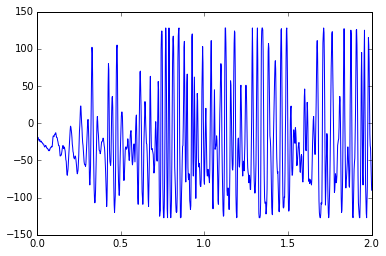

In [63]:
t = np.linspace(0, 2.000, i.shape[0])

a = i[:,100,0] - 127
plt.plot(t, a)
plt.show()

In [8]:
fs = len(t) / 2.000
fs

346.0

### Image statistics

In [9]:
r, g, b = i[...,0], i[...,1], i[...,2]

In [10]:
brightness = np.sqrt(0.299 * r**2. + 0.587 * g**2. + 0.114 * b**2.) - 127
brightness

array([[   6.,   -9.,   -1., ...,  -12.,  -21.,    1.],
       [  11.,  -13.,    1., ...,  -14.,  -22.,    4.],
       [   8.,  -12.,    1., ...,  -13.,  -21.,    2.],
       ..., 
       [  65.,   68.,   68., ...,  122.,  128.,  119.],
       [  63.,   64.,   64., ...,  128.,  124.,  115.],
       [  44.,   43.,   40., ...,  118.,   96.,   76.]])

In [11]:
from PIL import ImageStat
s = ImageStat.Stat(im)
print(s.sum)
sum(s.sum[:3])/3 == s.sum[0]

[58906233.0, 58906233.0, 58906233.0]


True

In [12]:
np.mean(im)

128.19972012326764

In [13]:
np.std(im)

31.511565509990128

In [14]:
import uuid
uuid.uuid1()

UUID('c8386db6-1528-11e5-89bb-a820663a5ca4')

In [15]:
np.array([[1,2,3],[4,5,6]]).shape

(2, 3)

###Cropping

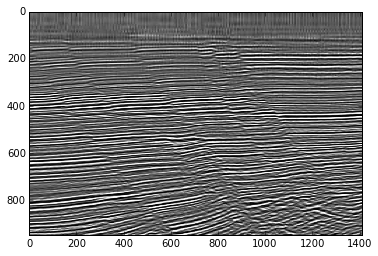

In [16]:
url2 = "https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg"
r2 = requests.get(url2)
im2 = Image.open(BytesIO(r2.content))

region = '199,141,1608,1087'
reg = [int(n) for n in region.split(',')]
i2 = im2.crop(reg)
plt.imshow(i2)
plt.show()

<hr />

##Frequency estimation

Much of this is from [Endolith's frequency estimator code](https://gist.github.com/endolith/255291)

###Count zero-crossings, divide average period by time to get frequency

* Works well for long low-noise sines, square, triangle, etc.
* Supposedly this is how cheap guitar tuners work
* Using interpolation to find a "truer" zero-crossing gives better accuracy
* Pro: Fast
* Pro: Accurate (increasing with signal length)
* Con: Doesn't work if there are multiple zero crossings per cycle, low-frequency baseline shift, noise, etc.



In [17]:
def freq_from_crossings(sig, fs):
    """
    Estimate frequency by counting zero crossings
    
    """
    # Find all indices right before a rising-edge zero crossing.
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))
    
    # Use linear interpolation to find intersample zero-crossings.
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    
    return fs / np.mean(np.diff(crossings))

In [18]:
freq_from_crossings(a, fs)

26.138125720647292

### Do FFT and find the peak

* Using parabolic interpolation to find a truer peak gives better accuracy
* Accuracy also increases with signal/FFT length
* Con: Doesn't find the right value if harmonics are stronger than fundamental, which is common.  Better method would try to be smarter about identifying the fundamental, like template matching using the ["two-way mismatch" (TWM) algorithm](http://ems.music.uiuc.edu/beaucham/papers/JASA.04.94.pdf).
* Pro: Accurate, usually even more so than zero crossing counter (1000.000004 Hz for 1000 Hz, for instance).  Due to [parabolic interpolation being a very good fit](https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html) for windowed log FFT peaks?

In [19]:
def freq_from_fft(signal, fs):
    """
    Estimate frequency from peak of FFT
    
    """
    # Compute Fourier transform of windowed signal.
    windowed = signal * blackmanharris(len(signal))
    f = rfft(windowed)
    
    # Find the peak and interpolate to get a more accurate peak.
    i = argmax(abs(f)) # Just use this for less-accurate, naive version.
    true_i = parabolic(log(abs(f)), i)[0]
    
    # Convert to equivalent frequency.
    return fs * true_i / len(windowed)

In [20]:
freq_from_fft(a, fs)

25.890437846159173

### Do autocorrelation and find the peak

* Pro: Best method for finding the true fundamental of any repetitive wave, even with weak or missing fundamental (finds GCD of all harmonics present)
* Con: Inaccurate result if waveform isn't perfectly repeating, like inharmonic musical instruments (piano, guitar, ...), however:
 * Pro: This inaccurate result more closely matches the pitch that humans perceive :)
* Con: Not as accurate as other methods for precise measurement of sine waves
* Con: This implementation has trouble with finding the true peak

In [21]:
def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    
    """
    # Seems to only work if all positive.
    sig = sig + 127
    
    # Calculate autocorrelation (same thing as convolution, but with 
    # one input reversed in time), and throw away the negative lags.
    corr = fftconvolve(sig, sig[::-1], mode='full')
    corr = corr[len(corr)/2:]
    
    # Find the first low point
    d = diff(corr)
    start = find(d > 0)[0]
    
    # Find the next peak after the low point (other than 0 lag).  This bit is 
    # not reliable for long signals, due to the desired peak occurring between 
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)
    
    return fs / px

In [22]:
freq_from_autocorr(a, fs)

24.828608394246523

### Calculate harmonic product spectrum and find the peak

* Pro: Good at finding the true fundamental even if weak or missing

In [23]:
def freq_from_HPS(signal, fs):
    """
    Estimate frequency using harmonic product spectrum (HPS)
    
    """
    windowed = signal * blackmanharris(len(signal))
 
    from pylab import subplot, plot, log, copy, show
 
    # Harmonic product spectrum.
    c = abs(rfft(windowed))
    maxharms = 8
    subplot(maxharms, 1, 1)
    plot(log(c))
    for x in range(2, maxharms):
        a = copy(c[::x]) # Should average or maximum instead of decimating.
        # max(c[::x],c[1::x],c[2::x],...)
        c = c[:len(a)]
        i = argmax(abs(c))
        
        try:
            true_i = parabolic(abs(c), i)[0]
        except IndexError as e:
            break

        print('Pass %d: %f Hz' % (x, fs * true_i / len(windowed)))
        c *= a
        subplot(maxharms,1,x)
        plot(log(c))
    show()

Pass 2: 25.900929 Hz
Pass 3: 12.100603 Hz
Pass 4: 6.222866 Hz
Pass 5: -0.007459 Hz


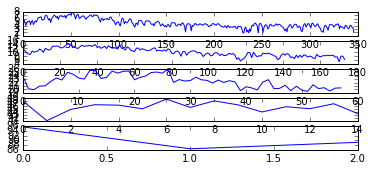

In [24]:
freq_from_HPS(a, fs)

<hr />

## Do ten and average

In [25]:
def get_freq(im, t_min, t_max, func):
    
    # Cast as array and centre on 0.
    i = np.asarray(im, dtype=int) - 127
       
    # Calculate a timebase.
    #t = np.linspace(t_min, t_max, i.shape[0])

    # Calculate the sampling frequency.
    fs = i.shape[0] / (t_max - t_min)
    
    # Get the slices we want.
    slices = np.arange(1/11.0,1,1/11.0) * i.shape[1]
    
    results = []
    for s in slices:
        a = i[:, s, 0]  # The RGB channels are all the same
        
        try:
            f = func(a, fs)
            results.append(f)
        except Exception as e:
            continue
    
    return scipy.stats.trim_mean(results, 0.2)

In [26]:
get_freq(im, 0, 2, freq_from_crossings)

26.494720855077123

In [27]:
get_freq(im, 0, 2, freq_from_fft)

27.620174961454822

In [28]:
get_freq(im, 0, 2, freq_from_autocorr)

33.215439729308258

<hr />

##Do all from URL

In [29]:
def image_freq(url, t_min, t_max):
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    try:
        f = get_freq(im, t_min, t_max, freq_from_crossings)
    except:
        f = get_freq(im, t_min, t_max, freq_from_autocorr)
    return f

In [30]:
url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_2000ms_12000m.png"
#url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_3000ms_8000m.png"

image_freq(url, 0, 2)

26.494720855077123

<hr />

## Phase

In [31]:
e = scipy.signal.hilbert(a)  # envelope

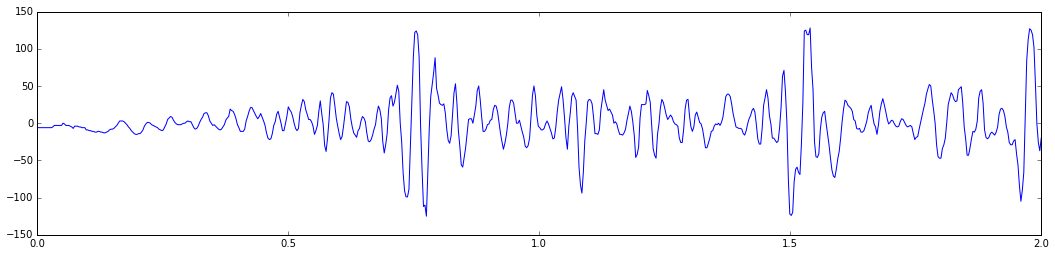

In [32]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.plot(t, e.real)
plt.show()

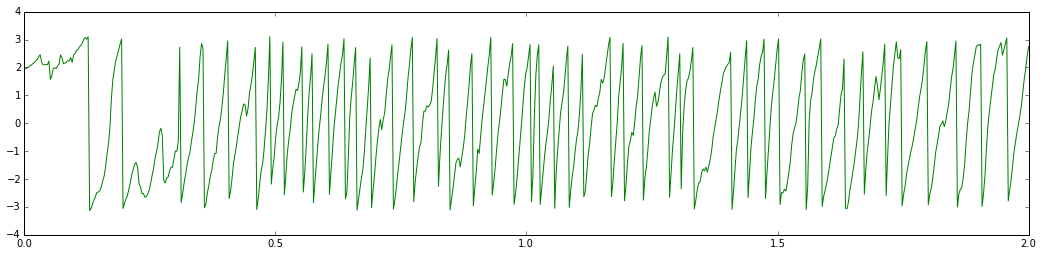

In [33]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.plot(t, np.angle(e), 'g')
plt.show()

In [34]:
i = argmax(abs(e))
true_i = parabolic(log(abs(e)+0.01), i)[0]  # Add small amount to avoid /0 warning
true_i

527.56489879124149

Get the naive angle:

In [35]:
rad = np.angle(e)[i]
np.degrees(rad)

-45.055564754039864

Let's compare with the interpolated angle:

In [36]:
x = np.arange(0, len(e))
rad = np.interp(true_i, x, np.angle(e))
np.degrees(rad)

-60.68913714158608

Big difference! 

OK, let's do this for every major peak...

In [37]:
results = []
for arr, env in zip(np.array_split(a, 10), np.array_split(e, 10)):
    i = argmax(abs(arr))
    true_i = parabolic(log(abs(arr)+0.01), i)[0]
    x = np.arange(0, len(arr))
    rad = np.interp(true_i, x, np.angle(env))
    results.append(np.degrees(rad))
scipy.stats.trim_mean(results, 0.2)

-29.775771106695178

In [38]:
results

[-169.78799526976721,
 -21.48418030269892,
 -1.7788162571531823,
 -49.714822365692157,
 -70.994650486568233,
 -90.8423441069814,
 -22.351144509833961,
 14.768808067857568,
 11.680272051457901,
 -12.331012718224629]

Not sure about this, since the arbitrary spitting into 10 subarrays means we might miss some good peaks, and conversely might include some rubbish ones. 

The new function `argpartition` can, by some sorcery, select the indices of the *n* largest values. We'll have to do something cunning to avoid choosing several from the same peak...

In [39]:
biggest = np.argpartition(e, -20)[-20:]
biggest

array([273, 514, 533, 681, 682, 686, 274, 259, 263, 262, 261, 683, 684,
       685, 260, 528, 530, 531, 532, 529])

In [40]:
s = np.vstack((biggest, e.real[biggest])).T
sort = s[s[:,1].argsort()][::-1]
sort

array([[ 532.,  128.],
       [ 683.,  127.],
       [ 684.,  125.],
       [ 529.,  125.],
       [ 528.,  124.],
       [ 261.,  124.],
       [ 260.,  122.],
       [ 685.,  119.],
       [ 531.,  119.],
       [ 530.,  119.],
       [ 262.,  119.],
       [ 682.,  112.],
       [ 686.,  102.],
       [ 263.,   89.],
       [ 274.,   88.],
       [ 259.,   88.],
       [ 681.,   84.],
       [ 533.,   75.],
       [ 514.,   71.],
       [ 273.,   68.]])

In [41]:
# This will be expensive so let's stick to small lists...
biggest_pruned = [sort[:,0][0]]
for ix in sort[:,0][1:]:
    add = True
    for got in biggest_pruned:
        if abs(ix - got) < 5:  # made-up number
            add = False
    if add:
        biggest_pruned.append(ix)
        if len(biggest_pruned) == 5: break
biggest_pruned

[532.0, 683.0, 261.0, 274.0, 514.0]

In [42]:
results = []
for ix in biggest_pruned:
    true_i = parabolic(np.log(abs(e)+0.01), ix)[0]
    x = np.arange(0, len(e))
    rad = np.interp(true_i, x, np.angle(e))
    results.append(np.degrees(rad))
print(results)
np.mean(results)

[24.171251103904069, -123.01015202377602, 5.0600071278045728, -19.621801854973885, 67.834938687142412]


-9.1131513919797698

OK, that's pretty cool.

<hr />

## Histogram

In [43]:
i = np.asarray(im, dtype=int) - 127
i = i[:,:,0]
hist = np.histogram(i, bins=16)

In [44]:
x = str(hist[1])
x

'[-127.     -111.0625  -95.125   -79.1875  -63.25    -47.3125  -31.375\n  -15.4375    0.5      16.4375   32.375    48.3125   64.25     80.1875\n   96.125   112.0625  128.    ]'

In [45]:
import json
json.dumps(str(x))

'"[-127.     -111.0625  -95.125   -79.1875  -63.25    -47.3125  -31.375\\n  -15.4375    0.5      16.4375   32.375    48.3125   64.25     80.1875\\n   96.125   112.0625  128.    ]"'

<hr />

## Signal:noise

Could treat as image and do mean/std, but wiggles give articifial STD.

Could model trace (or trace segments) as sine wave (say) and diff with signal to find noise.

Could treat low band as signal and higher band as noise. E.g. half-peak to twice-peak freq as signal, and four-times to Nyquist as noise.

Some code here from Warren Weckesser. 

In [46]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


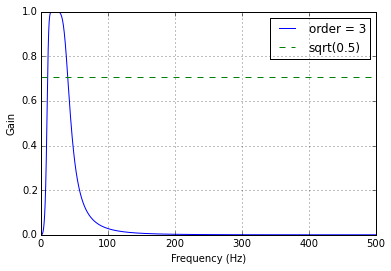

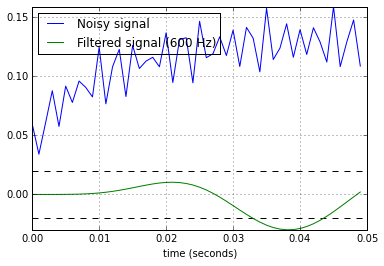

In [47]:
from scipy.signal import freqz
    
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 10.0
highcut = 40.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
T = 0.05
nsamples = T * fs
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)
plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')

y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

<hr />

##Wavelet estimation

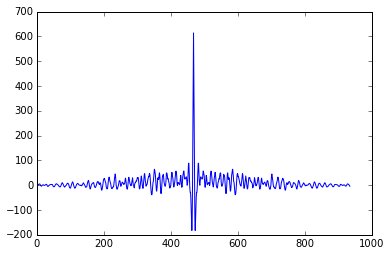

In [64]:
windowed = a * blackmanharris(len(a))
w = irfft(abs(rfft(windowed)))
plt.plot(np.fft.fftshift(w))

Maybe just send back average spectrum, and the user can do what they want with it.

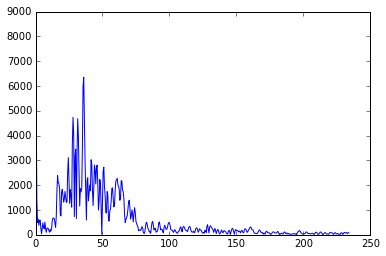

In [65]:
windowed = a * blackmanharris(len(a))
p = abs(rfft(windowed))
dt = (2.0 - 0.0) / len(a)
f = np.fft.rfftfreq(len(a), dt)
plt.plot(f, p)

Can estimate f_max from this, because we can find the noise floor.

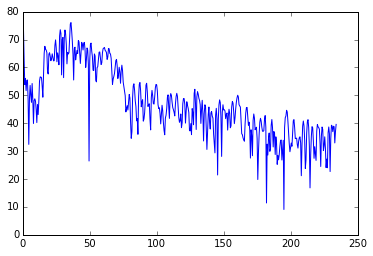

In [66]:
plt.plot(f, 20*np.log10(p))

In [67]:
db = 20*np.log10(p)
peak = np.argmax(db)
true_i = parabolic(log(abs(db)+0.001), peak)[0]

# Now backinterpolate
x = np.arange(0, len(f))
f_peak = np.interp(true_i, x, f)
print(f_peak)

0.2175784232888822


Note that this is Yet Another Estimate of the peak frequency :)

Now go 20 dB down and get the frequency there. 

In [68]:
np.amax(db) - 20

58.211979547604642

In [69]:
db = 20*np.log10(p)
sig = db - np.amax(db) + 20
indices = find((sig[1:] >= 0) & (sig[:-1] < 0))
crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
mi, ma = np.min(crossings), np.amax(crossings)
f_min = np.interp(mi, x, f)
f_max = np.interp(ma, x, f)
f_min, f_max

(15.551736685816877, 73.44158425507908)

<hr />

##Segmentation

In [172]:
from skimage import data
coins = data.coins()
histo = np.histogram(coins, bins=np.arange(0, 256))

In [173]:
from skimage.feature import canny
edges = canny(coins/255.)

In [174]:
from scipy import ndimage
fill_coins = ndimage.binary_fill_holes(edges)

In [175]:
label_objects, nb_labels = ndimage.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]

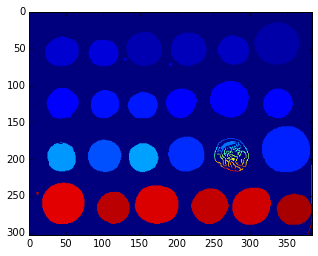

In [179]:
plt.imshow(label_objects)

In [180]:
nb_labels

113

In [192]:
from skimage.filters import sobel
elevation_map = sobel(coins)
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
segmentation = ndimage.binary_fill_holes(segmentation - 1)
labeled_coins, nb_labels = ndimage.label(segmentation)

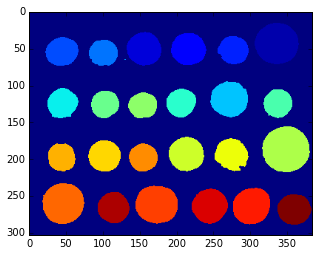

In [193]:
plt.imshow(labeled_coins)

In [196]:
from skimage import measure
props = measure.regionprops(labeled_coins)

In [195]:
measure.regionprops?

In [206]:
for p in props:
    print(p.label)
    print(p.area)
    print(p.bbox)

1
2604.0
(16, 305, 72, 365)
2
1653.0
(28, 132, 74, 179)
3
1622.0
(30, 192, 73, 240)
4
1225.0
(34, 255, 72, 297)
5
1355.0
(35, 22, 74, 67)
6
1103.0
(39, 81, 74, 120)
7
2.0
(65, 129, 66, 131)
8
1920.0
(95, 245, 144, 296)
9
1298.0
(104, 25, 145, 67)
10
1209.0
(105, 186, 144, 226)
11
1175.0
(106, 317, 145, 356)
12
1111.0
(108, 84, 145, 122)
13
1077.0
(110, 134, 145, 173)
14
3141.0
(156, 315, 218, 380)
15
1737.0
(170, 189, 217, 237)
16
1496.0
(172, 251, 217, 297)
17
1471.0
(175, 80, 217, 124)
18
1124.0
(179, 26, 217, 63)
19
1152.0
(179, 135, 217, 174)
20
2461.0
(233, 18, 288, 75)
21
2350.0
(236, 144, 288, 201)
22
1993.0
(239, 276, 289, 326)
23
1765.0
(240, 220, 288, 269)
24
1416.0
(245, 93, 287, 136)
25
1485.0
(248, 336, 289, 382)


In [ ]:
from skimage.segmentation import slic

In [219]:
url = "https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg"
r = requests.get(url)
im = Image.open(BytesIO(r.content))

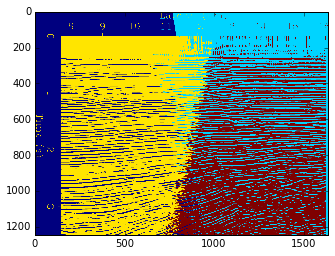

In [228]:
segments = slic(im, n_segments=4, compactness=50)
plt.imshow(segments)

## Image segmentation from Yoink

In [37]:
from scipy import ndimage
from skimage import img_as_uint
from skimage.measure import approximate_polygon
from skimage.feature import corner_harris

def guess_corners(bw):
    """
    Infer the corners of an image using a Sobel filter to find the edges and a
    Harris filter to find the corners.  Takes a single color chanel.
    Parameters
    ----------
    bw : (m x n) ndarray of ints
    Returns
    -------
    corners : pixel coordinates of plot corners, unsorted
    outline : (m x n) ndarray of bools True -> plot area
    """
    assert len(bw.shape) == 2
    bw = img_as_uint(bw)
    e_map = ndimage.sobel(bw)

    markers = np.zeros(bw.shape, dtype=int)
    markers[bw < 20] = 1
    markers[bw > 200] = 2
    seg = ndimage.watershed_ift(e_map, np.asarray(markers, dtype=int))
    plt.imshow(markers)

    outline = ndimage.binary_fill_holes(1 - seg)
    corners = corner_harris(np.asarray(outline))
    print(corners.shape)
    corners = approximate_polygon(corners, 1)
    return corners, outline


(1245, 1636)


ValueError: too many values to unpack (expected 2)

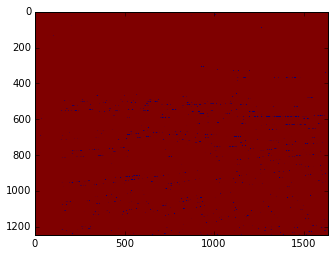

In [38]:
j = np.asarray(im)[...,0]
guess_corners(j)